# Music Collection Analysis

##### This notebook analyses and visualies the features of the music collection. In this case, the MusAV dataset.

    Note: All the plots are interactive, so use your mouse to explore.
    Expand the input cells to see the code.

In [ ]:
import json
import os
from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import scipy.cluster.hierarchy as sch
import seaborn as sns
from plotly.subplots import make_subplots
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from tqdm import tqdm

In [ ]:
# Static plot settings
plt.style.use("seaborn-v0_8-deep")
sns.set_palette("husl")
plt.rcParams.update(
    {
        "figure.figsize": (12, 8),
        "font.size": 12,
        "axes.titlesize": 16,
        "axes.labelsize": 14,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 12,
    }
)

## Data Loading and Processing

Load the JSON analysis files and prepare the data for visualization.

In [6]:
def load_analysis_files(analysis_dir: str) -> pd.DataFrame:
    """Load and process analysis files"""
    json_files = []
    for root, _, files in os.walk(analysis_dir):
        for f in files:
            if f.endswith(".json"):
                json_files.append(os.path.join(root, f))

    data = []
    for json_file in tqdm(json_files, desc="Loading files"):
        try:
            with open(json_file) as f:
                entry = json.load(f)
                entry["path"] = os.path.relpath(json_file, analysis_dir)
                data.append(entry)
        except Exception as e:
            print(f"Skipping {json_file}: {str(e)}")

    return pd.DataFrame(data)


def process_genres(genres: Dict) -> List[Dict]:
    """Process genre entries with proper separator handling"""
    processed = []
    for genre_str, prob in genres.items():
        if "---" in genre_str:
            parts = genre_str.split("---", 1)
        elif "—" in genre_str:
            parts = genre_str.split("—", 1)
        else:
            parts = [genre_str, "unknown-style"]

        parent = parts[0].strip()
        style = parts[1].strip() if len(parts) > 1 else "unknown-style"
        processed.append({"parent": parent, "style": style, "probability": prob})
    return processed


# Load data
analysis_dir = "results/fusion"
df = load_analysis_files(analysis_dir)

# Preprocess data
df["genres_processed"] = df["music_styles"].apply(process_genres)
key_profiles = ["temperley", "krumhansl", "edma"]
for profile in key_profiles:
    df[f"key_{profile}"] = df["key"].apply(
        lambda x: f"{x[profile]['key']} {x[profile]['scale'].capitalize()}"
    )

Loading files: 100%|██████████| 69/69 [00:00<00:00, 2153.23it/s]


Using TSNE random_state=292473


/var/folders/n1/mcq0j79n6y55kkrdd26_v_qr0000gn/T/ipykernel_3749/1943224608.py:124: ClusterWarning:

The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



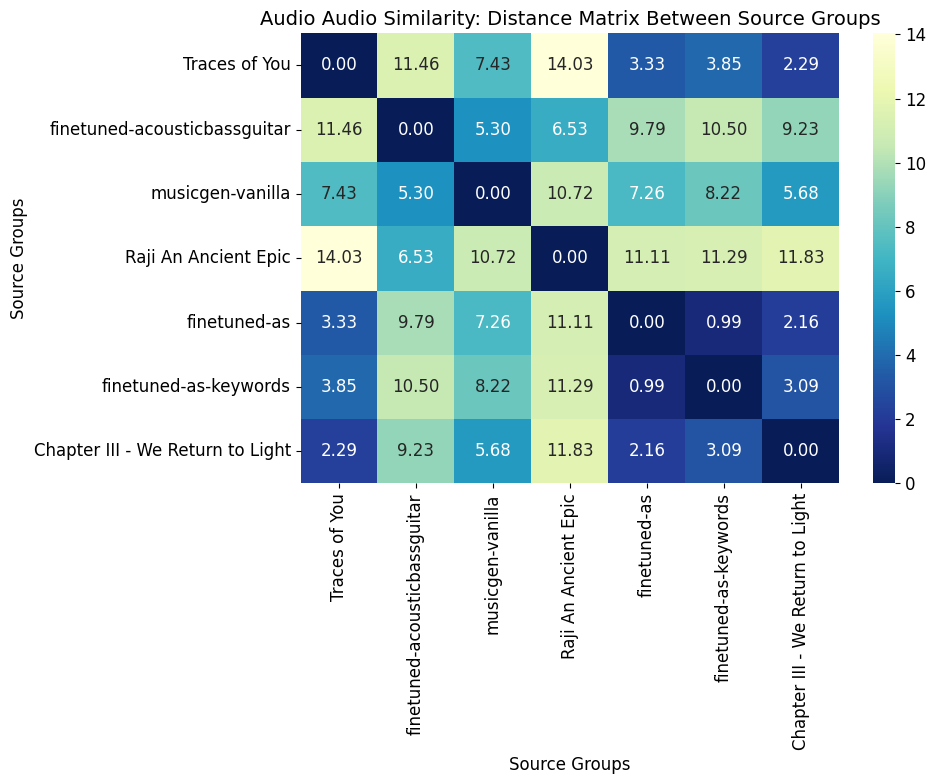

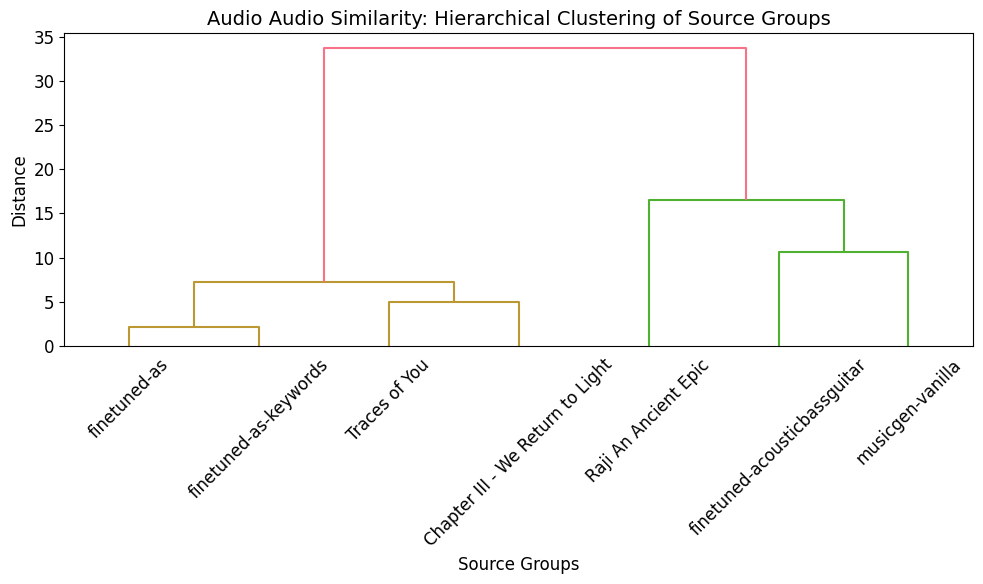

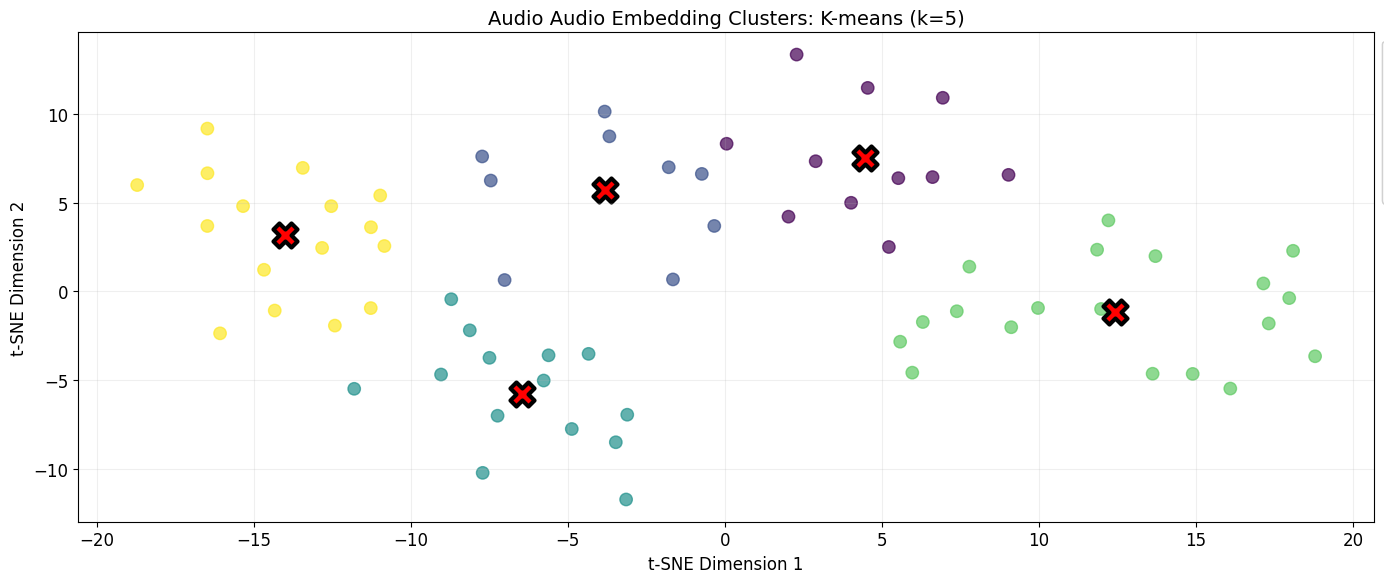

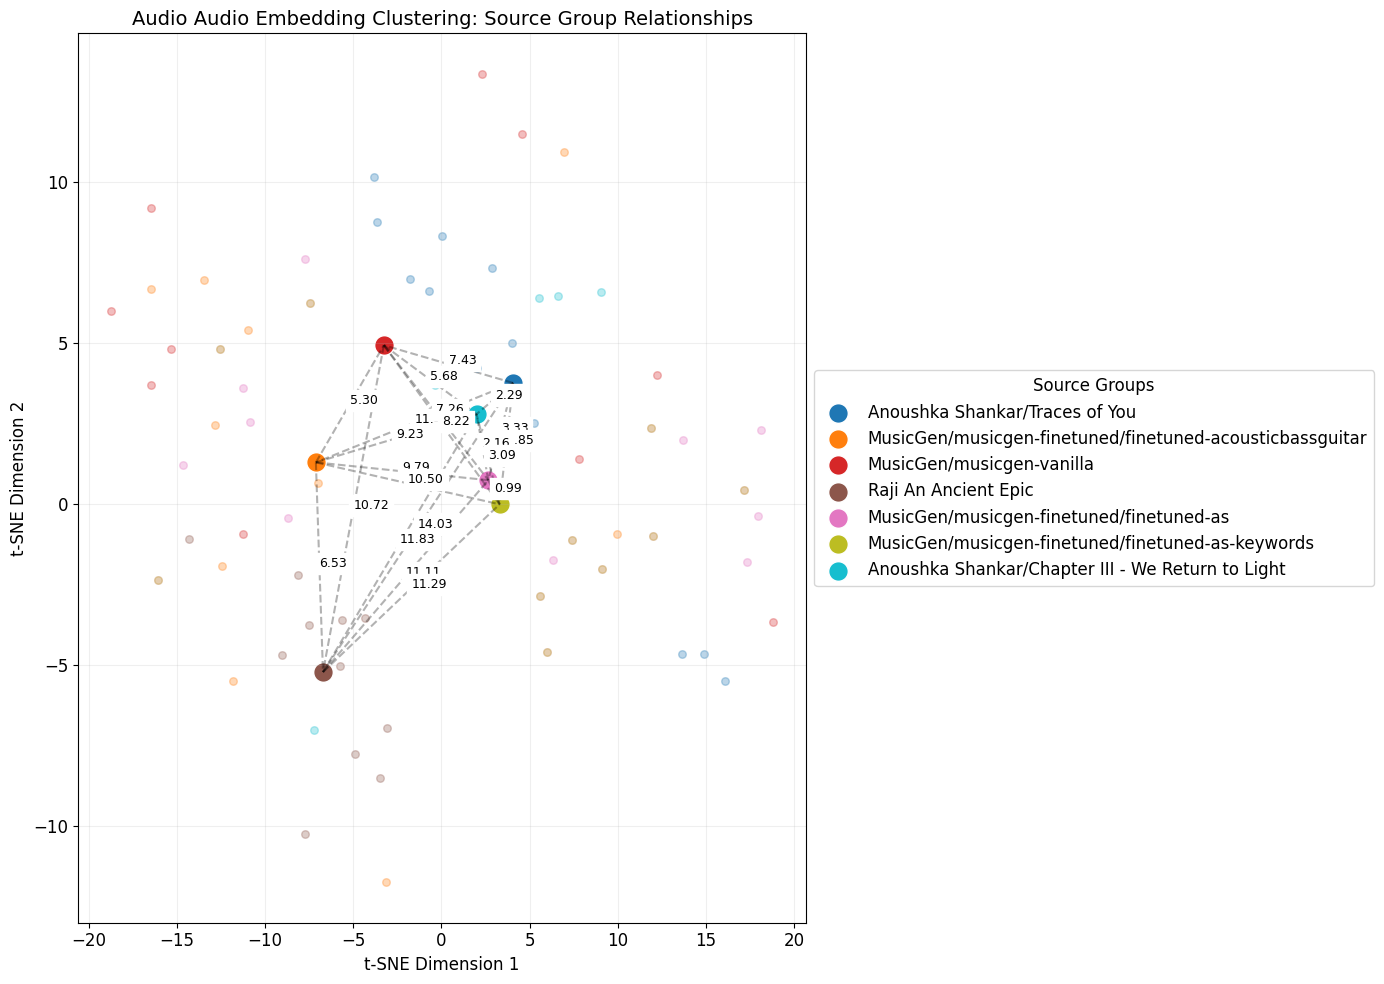

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

In [ ]:
def create_source_groups(X_tsne, df):
    """Extract source groups and their centroids from the data"""
    # Identify the unique sources from paths
    sources = set()
    for _, row in df.iterrows():
        path = row.get("path", "")
        if path:
            parts = path.split("/")
            if len(parts) > 0:
                source = parts[0] if len(parts) == 1 else "/".join(parts[:-1])
                sources.add(source)

    # Calculate centroids for each source group
    source_centroids = {}
    source_points = {}
    for source in sources:
        indices = []
        for i, row in df.iterrows():
            path = row.get("path", "")
            if path and source in path:
                indices.append(i)

        if indices:
            group_points = X_tsne[indices]
            source_centroids[source] = np.mean(group_points, axis=0)
            source_points[source] = group_points

    # Create distance matrix between source centroids
    source_names = list(source_centroids.keys())
    centroid_matrix = np.array([source_centroids[source] for source in source_names])
    distance_matrix = squareform(pdist(centroid_matrix, "euclidean"))

    return source_names, source_centroids, source_points, distance_matrix


def plot_centroid_map(X_tsne, df, title_prefix):
    """Plot source group centroids with distances between them"""
    source_names, source_centroids, source_points, distance_matrix = (
        create_source_groups(X_tsne, df)
    )

    # Create a large figure
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111)

    # Generate colors for each source
    colors = plt.cm.tab10(np.linspace(0, 1, len(source_names)))

    # Plot centroids
    for i, source in enumerate(source_names):
        ax.scatter(
            source_centroids[source][0],
            source_centroids[source][1],
            s=200,
            color=colors[i],
            label=source,
            edgecolor="white",
        )

        # Plot source group points
        group_points = source_points[source]
        ax.scatter(
            group_points[:, 0], group_points[:, 1], s=30, color=colors[i], alpha=0.3
        )

    # Draw lines and show distances between centroids
    for i in range(len(source_names)):
        for j in range(i + 1, len(source_names)):
            x1, y1 = source_centroids[source_names[i]]
            x2, y2 = source_centroids[source_names[j]]
            ax.plot([x1, x2], [y1, y2], "k--", alpha=0.3)

            # Calculate midpoint for text label
            mid_x = (x1 + x2) / 2
            mid_y = (y1 + y2) / 2
            dist = distance_matrix[i, j]
            ax.annotate(
                f"{dist:.2f}", (mid_x, mid_y), backgroundcolor="white", fontsize=9
            )

    ax.set_title(
        f"{title_prefix} Audio Embedding Clustering: Source Group Relationships",
        fontsize=14,
    )
    ax.set_xlabel("t-SNE Dimension 1", fontsize=12)
    ax.set_ylabel("t-SNE Dimension 2", fontsize=12)
    ax.legend(title="Source Groups", loc="center left", bbox_to_anchor=(1, 0.5))
    ax.grid(alpha=0.2)
    plt.tight_layout()

    return fig


def plot_distance_heatmap(X_tsne, df, title_prefix):
    """Plot distance heatmap between source groups"""
    source_names, _, _, distance_matrix = create_source_groups(X_tsne, df)

    # Create a large figure
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111)

    # Get simplified names for labels
    simplified_names = [s.split("/")[-1] for s in source_names]

    # Create heatmap
    sns.heatmap(
        distance_matrix,
        annot=True,
        fmt=".2f",
        cmap="YlGnBu_r",
        xticklabels=simplified_names,
        yticklabels=simplified_names,
        ax=ax,
    )

    ax.set_title(
        f"{title_prefix} Audio Similarity: Distance Matrix Between Source Groups",
        fontsize=14,
    )
    ax.set_xlabel("Source Groups", fontsize=12)
    ax.set_ylabel("Source Groups", fontsize=12)
    plt.tight_layout()

    return fig


def plot_hierarchical_clustering(X_tsne, df, title_prefix):
    """Plot hierarchical clustering dendrogram of source groups"""
    source_names, _, _, distance_matrix = create_source_groups(X_tsne, df)

    # Create a large figure
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)

    # Get simplified names for labels
    simplified_names = [s.split("/")[-1] for s in source_names]

    # Create dendrogram
    linked = sch.linkage(distance_matrix, method="ward")
    sch.dendrogram(
        linked,
        labels=simplified_names,
        ax=ax,
        leaf_font_size=12,
        leaf_rotation=45,
        color_threshold=0.7 * max(linked[:, 2]),
    )

    ax.set_title(
        f"{title_prefix} Audio Similarity: Hierarchical Clustering of Source Groups",
        fontsize=14,
    )
    ax.set_xlabel("Source Groups", fontsize=12)
    ax.set_ylabel("Distance", fontsize=12)
    plt.tight_layout()

    return fig


def plot_kmeans_clustering(X_tsne, df, title_prefix):
    """Plot K-means clustering of the data points"""
    # Determine optimal number of clusters
    k = min(5, len(X_tsne) // 5)

    # Create a large figure
    fig = plt.figure(figsize=(14, 6))
    ax = fig.add_subplot(111)

    # Apply K-means
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_tsne)

    # Plot points colored by k-means cluster
    scatter = ax.scatter(
        X_tsne[:, 0], X_tsne[:, 1], c=kmeans.labels_, cmap="viridis", s=80, alpha=0.7
    )

    # Plot k-means centroids
    ax.scatter(
        kmeans.cluster_centers_[:, 0],
        kmeans.cluster_centers_[:, 1],
        marker="X",
        s=300,
        linewidths=3,
        color="red",
        edgecolor="black",
        label="Cluster Centroids",
    )

    # Add a legend for k-means clustering
    legend1 = ax.legend(
        *scatter.legend_elements(),
        title="Clusters",
        loc="upper left",
        bbox_to_anchor=(1, 1),
    )
    ax.add_artist(legend1)

    # # Add a second legend for centroids
    # ax.legend(handles=[plt.Line2D([0], [0], marker='X', color='w', markerfacecolor='red',
    #                              markersize=15, label='Cluster Centroids')],
    #          loc='upper left', bbox_to_anchor=(1, 0.9))

    ax.set_title(
        f"{title_prefix} Audio Embedding Clusters: K-means (k={k})", fontsize=14
    )
    ax.set_xlabel("t-SNE Dimension 1", fontsize=12)
    ax.set_ylabel("t-SNE Dimension 2", fontsize=12)
    ax.grid(alpha=0.2)
    plt.tight_layout()

    return fig


# Extract embeddings from the dataframe
embeddings_list = []
for _, row in df.iterrows():
    # Convert string representation of embeddings dict to actual dict
    embed_dict = row["embeddings"]
    if isinstance(embed_dict, str):
        embed_dict = json.loads(embed_dict)
    # Use the embedding model's vector (discogs-effnet)
    if "discogs-effnet" in embed_dict:
        embeddings_list.append(embed_dict["discogs-effnet"])
    else:
        # Fallback to zero vector if no embedding is found
        embeddings_list.append([0.0] * 32)  # assuming 32 dimensions

embeddings_array = np.array(embeddings_list)

tsne = TSNE(
    n_components=2, perplexity=10, random_state=182730
)  # 80086, 182730, 559104, 597925, 636172
X_tsne_embed = tsne.fit_transform(embeddings_array)

# Create individual plots
fig_centroid_map = plot_centroid_map(X_tsne_embed, df, "Audio")
fig_distance_heatmap = plot_distance_heatmap(X_tsne_embed, df, "Audio")
fig_hierarchical = plot_hierarchical_clustering(X_tsne_embed, df, "Audio")
fig_kmeans = plot_kmeans_clustering(X_tsne_embed, df, "Audio")

# Display each visualization separately
plt.figure(fig_centroid_map.number)
plt.show()

plt.figure(fig_distance_heatmap.number)
plt.show()

plt.figure(fig_hierarchical.number)
plt.show()

plt.figure(fig_kmeans.number)
plt.show()


## Genre & Style Analysis

Analyze the distribution of music genres and sub-genres in the collection.

In [4]:
# Process genre data
parent_data = []
for track in df.genres_processed:
    total = sum(g["probability"] for g in track)
    for genre in track:
        parent_data.append(
            {
                "parent": genre["parent"],
                "style": genre["style"],
                "weight": genre["probability"] / total,
            }
        )

parent_df = pd.DataFrame(parent_data)
parent_totals = parent_df.groupby(["parent", "style"])["weight"].sum().reset_index()
parent_summary = parent_totals.groupby("parent")["weight"].sum().reset_index()

# Sort parent genres by weight in descending order
parent_summary = parent_summary.sort_values(by="weight", ascending=False)

# Sort styles within each parent genre by weight in descending order
parent_totals = parent_totals.sort_values(
    by=["parent", "weight"], ascending=[True, False]
)

# Define a dictionary to store the sorted order of styles for each parent genre
style_order = {}
for parent in parent_summary["parent"]:
    # Get the styles for the current parent genre and sort them by weight in descending order
    styles = (
        parent_totals[parent_totals["parent"] == parent]
        .sort_values(by="weight", ascending=False)["style"]
        .tolist()
    )
    # Add the sorted styles to the style_order dictionary
    style_order[parent] = styles

# Interactive plot
fig = px.bar(
    parent_totals,
    x="parent",
    y="weight",
    color="style",
    hover_data=["style", "weight"],
    title="Genre & Style Distribution",
    labels={"weight": "Weight", "parent": "Genre"},
    category_orders={
        "parent": parent_summary["parent"].tolist(),
        "style": [
            style
            for parent in parent_summary["parent"]
            for style in style_order[parent]
        ],
    },
)

fig.update_layout(xaxis_tickangle=-45, height=700, showlegend=False)

fig.show()


In [ ]:
fig = px.treemap(
    parent_totals,
    path=["parent", "style"],
    values="weight",
    title="<b>Genre & Styles Distribution</b>",
    color="weight",
    color_continuous_scale="viridis",
    hover_data=["style", "weight"],
)

fig.update_layout(
    margin=dict(t=50, l=25, r=25, b=25),
    treemapcolorway=["#264653", "#2a9d8f", "#e9c46a", "#f4a261", "#e76f51"],
    title_x=0.5,
    font=dict(size=14, color="#333"),
)

fig.update_traces(
    textinfo="label+value+percent parent",
    textfont_size=12,
    marker=dict(line=dict(width=2, color="#fff")),
)

fig.update_layout(
    height=700,  # Adjust the height as needed
    width=1300,  # Adjust the width as needed
)

fig.show()
